# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Mahdi Mansouri

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [1]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/DeepLearning/HW2/"
os.makedirs(data_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Device

Set device to work with (GPU or CPU)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def __call__(self, tensor):
        return tensor * self.std + self.mean

norminv = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))

In [7]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s]


In [8]:
trainset, valset = train_test_split(initial_trainset, test_size=0.2, random_state=42)

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False)

In [10]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [11]:
def get_data(dataloader):
  input_tensors = torch.tensor([])
  target_tensors = torch.tensor([])
  for batch_idx, (inputs, targets) in enumerate(dataloader):
      input_tensors = torch.cat((input_tensors, inputs))
      target_tensors = torch.cat((target_tensors, targets))

  return input_tensors, target_tensors

train_img, train_target = get_data(trainloader)

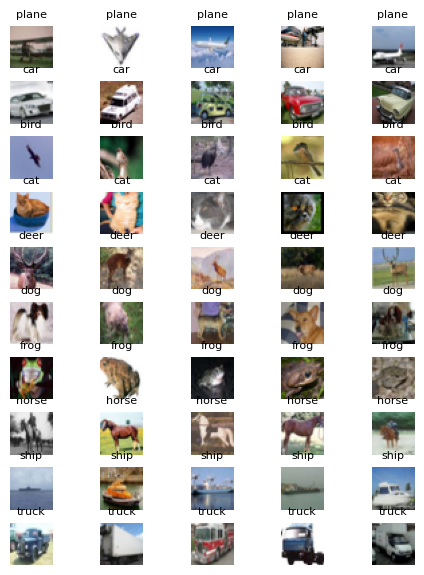

In [ ]:
W_grid = 5
L_grid = 10
fig, axes = plt.subplots(L_grid, W_grid, figsize=(7, 7))

for class_label in range(L_grid):
    indices = np.where(train_target == class_label)[0]
    random_indices = np.random.choice(indices, W_grid, replace=False)
    for i, idx in enumerate(random_indices):
        ax = axes[class_label, i]
        image_tensor = train_img[idx]
        image = norminv(image_tensor).numpy()
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(classes[class_label], fontsize=6)
        ax.axis('off')

plt.subplots_adjust(hspace=0.3, wspace=-0.5)

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [14]:
net = ResNet(BasicBlock, [2, 2, 2, 2])

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [16]:
import tqdm
from time import time

In [17]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler, dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    scheduler.step()

    loss = running_loss / len(dataloader)
    accuracy = 100. * correct/total
    return loss, accuracy


def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    loss = running_loss / len(dataloader)
    accuracy = 100. * correct/total
    return loss, accuracy


In [18]:
model_path = data_path + 'resnet18.pt'

epochs = 30

best_valid_loss = float('inf')
best_valid_acc = 0

accuracy_hist, loss_hist = {}, {}
loss_hist['train'], loss_hist['valid'] = [], []
accuracy_hist['train'], accuracy_hist['valid'] = [], []

for e in range(epochs):
  train_loss, train_acc = train_epoch(net, criterion, optimizer, scheduler, trainloader)
  valid_loss, valid_acc = eval_epoch(net, criterion, valloader, test_mode = False)

  loss_hist['train'].append(train_loss)
  loss_hist['valid'].append(valid_loss)
  accuracy_hist['train'].append(train_acc)
  accuracy_hist['valid'].append(valid_acc)

  # Save checkpoint
  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_valid_loss = valid_loss
    torch.save(net.state_dict(), model_path)

  print(f'Epoch [{e+1}/{epochs}] - '
          f'Train Loss: {train_loss:.4f} - '
          f'Train Accuracy: {train_acc:.4f} - '
          f'Valid Loss: {valid_loss:.4f} - '
          f'Valid Accuracy {valid_acc:.4f}%')

Epoch [1/30] - Train Loss: 1.2758 - Train Accuracy: 53.4425 - Valid Loss: 1.0682 - Valid Accuracy 62.1900%
Epoch [2/30] - Train Loss: 0.7968 - Train Accuracy: 71.7225 - Valid Loss: 0.8787 - Valid Accuracy 69.5600%
Epoch [3/30] - Train Loss: 0.5814 - Train Accuracy: 79.3675 - Valid Loss: 0.6790 - Valid Accuracy 76.8500%
Epoch [4/30] - Train Loss: 0.4376 - Train Accuracy: 84.5825 - Valid Loss: 0.6511 - Valid Accuracy 78.3100%
Epoch [5/30] - Train Loss: 0.2960 - Train Accuracy: 89.5800 - Valid Loss: 0.7968 - Valid Accuracy 76.2200%
Epoch [6/30] - Train Loss: 0.1821 - Train Accuracy: 93.7375 - Valid Loss: 0.6516 - Valid Accuracy 80.4200%
Epoch [7/30] - Train Loss: 0.0996 - Train Accuracy: 96.6600 - Valid Loss: 0.8583 - Valid Accuracy 78.2500%
Epoch [8/30] - Train Loss: 0.0576 - Train Accuracy: 98.0600 - Valid Loss: 0.8141 - Valid Accuracy 79.6600%
Epoch [9/30] - Train Loss: 0.0358 - Train Accuracy: 98.8175 - Valid Loss: 0.7558 - Valid Accuracy 82.2500%
Epoch [10/30] - Train Loss: 0.0223 - 

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

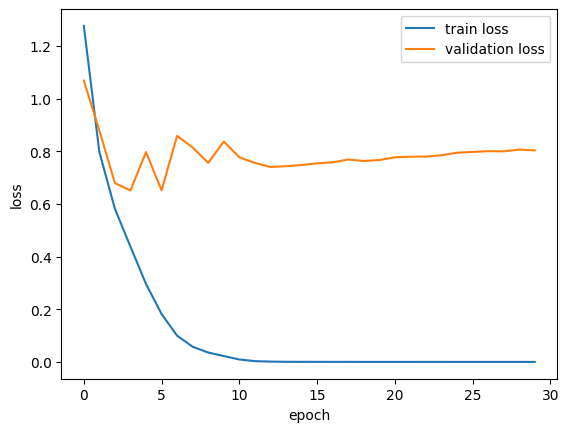

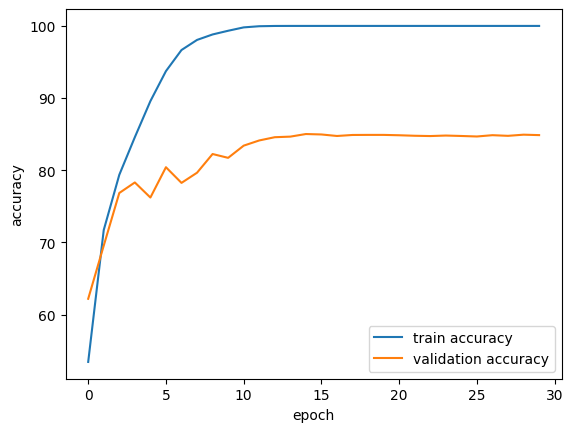

In [19]:
# TODO

def plot(history, metric='accuracy'):
  epochs = np.arange(len(history['train']))
  plt.plot(epochs, history['train'], label='train ' + metric)
  plt.plot(epochs, history['valid'], label='validation ' + metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

plot(loss_hist, 'loss')
plot(accuracy_hist, 'accuracy')

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [20]:
# A dictionary to store our captured activation
activation = {}

def get_activation(name):
    """
    This function creates and returns a hook.
    The hook captures the output of a layer during the forward pass.
    """
    def hook(model, input, output):
        # The output of the avgpool layer is (batch_size, 512, 1, 1).
        # We detach it from the graph and flatten it to get the feature vector.
        activation[name] = output.detach().view(output.size(0), -1)
    return hook




In [21]:
net = ResNet(BasicBlock, [2, 2, 2, 2])
model_path = data_path + 'resnet18.pt'

net.load_state_dict(torch.load(model_path, map_location=device))

net.avgpool.register_forward_hook(get_activation('feature-space'))

net.to(device)

print("Hook successfully registered on the 'avgpool' layer of the ResNet model.")

Hook successfully registered on the 'avgpool' layer of the ResNet model.


In [22]:
 test_loss, test_acc = eval_epoch(net, criterion, testloader, test_mode=True)

 print(f'Test Loss: {test_loss:.4f} - '
       f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.7671 - Test Accuracy: 84.4100


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

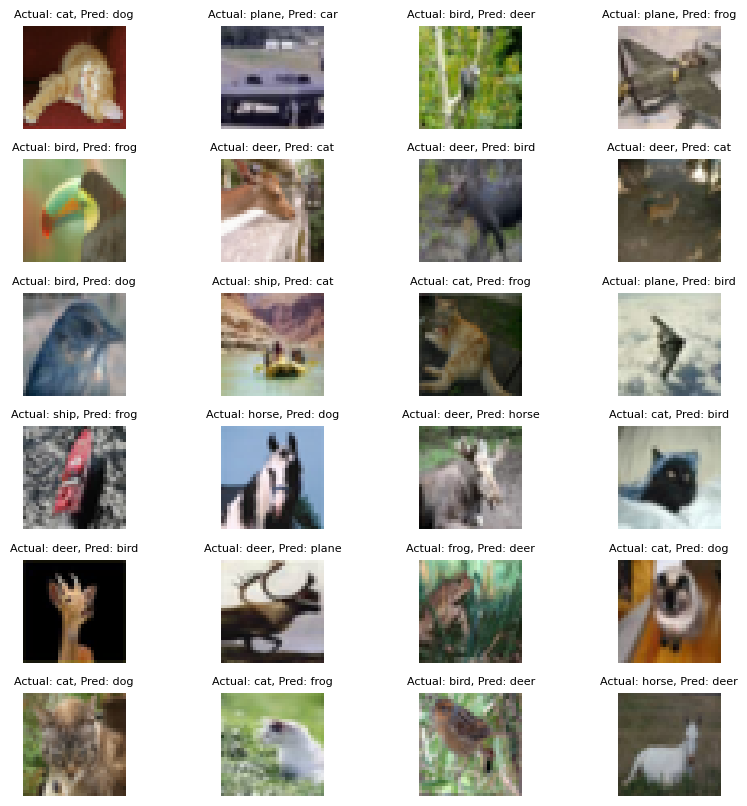

In [23]:
# TODO
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_incorrect(net, dataloader):
  incorrect_samples = []
  for batch_idx, (inputs, targets) in enumerate(dataloader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      _, predicted = outputs.max(1)
      incorrets_indices = ( (((predicted == targets) == False) * (targets+1) - 1) >= 0 ).nonzero(as_tuple=True)[0]
      incorrect_samples.extend(zip(inputs[incorrets_indices].cpu(), targets[incorrets_indices].cpu(), predicted[incorrets_indices].cpu()))

  W_grid = 4
  L_grid = 6
  fig, axes = plt.subplots(L_grid, W_grid, figsize = (10, 10))

  axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
  n_train = len(trainset)
  for i in np.arange(0, W_grid * L_grid):
      index = np.random.randint(0, len(incorrect_samples))

      axes[i].imshow(np.transpose(norminv(incorrect_samples[index][0]), (1, 2, 0)))
      label_gt = incorrect_samples[index][1]
      label_pred = incorrect_samples[index][2]
      axes[i].set_title(f'Actual: {classes[label_gt]}, Pred: {classes[label_pred]}', fontsize = 8)
      axes[i].axis('off')

  plt.subplots_adjust(hspace=0.3, wspace=0.1)


plot_incorrect(net, testloader)

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [24]:
# TODO
trainloader_all = torch.utils.data.DataLoader(initial_trainset, batch_size=128, shuffle=True)


def get_featureSpace(net, dataloader):
  input_tensors = torch.tensor([])
  target_tensors = torch.tensor([])
  feature_spaces = torch.tensor([])
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(dataloader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = net(inputs)
          feature_spaces = torch.cat((feature_spaces, activation['feature-space'].cpu()))
          input_tensors = torch.cat((input_tensors, inputs.cpu()))
          target_tensors = torch.cat((target_tensors, targets.cpu()))

  return feature_spaces, input_tensors, target_tensors

feature_spaces, input_tensors, target_tensors = get_featureSpace(net, trainloader_all)
feature_spaces.shape

torch.Size([50000, 512])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

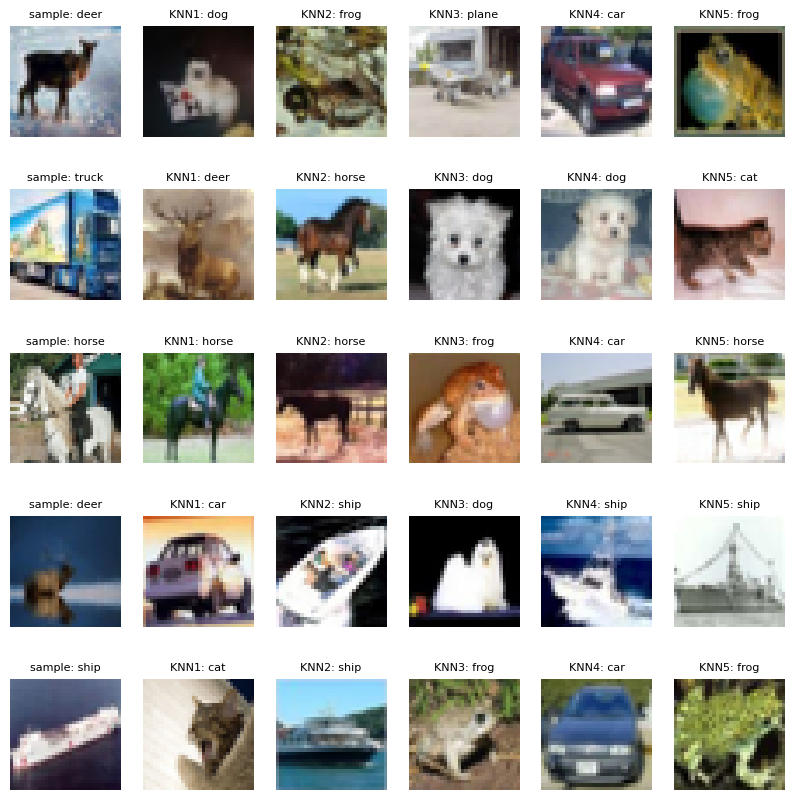

In [ ]:
# TODO

def get_correct(net, dataloader):
  correct_samples = []
  for batch_idx, (inputs, targets) in enumerate(dataloader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      _, predicted = outputs.max(1)
      correts_indices = ( ((predicted == targets) * (targets+1) - 1) >= 0 ).nonzero(as_tuple=True)[0]
      correct_samples.extend(zip(inputs[correts_indices].cpu(), targets[correts_indices].cpu()))

  return correct_samples


def findKNN(sample, feature_spaces):
  feature_spaces_norm = torch.linalg.norm(feature_spaces, dim=1)

  outputs = net(sample.to(device).unsqueeze(0))
  sample_fs = activation['feature-space'][0].cpu()

  abs_distance = torch.abs(feature_spaces_norm - torch.linalg.norm(sample_fs))
  return torch.topk(abs_distance, k=5, largest=False).indices # indices of KNN


np.random.seed(seed=21)
correct_samples = get_correct(net, testloader)
random_indices = np.random.randint(len(correct_samples), size=5)


fig, axs = plt.subplots(5, 6, figsize=(10, 10))
for i in range(len(random_indices)):
  sample, target = correct_samples[random_indices[i]]
  knn_indices = findKNN(sample, feature_spaces)

  axs[i, 0].imshow(np.transpose(norminv(sample), (1, 2, 0)))
  axs[i, 0].set_title(f'sample: {classes[target]}', fontsize = 8)
  axs[i, 0].axis('off')

  for j in range(1, 6):
    axs[i, j].imshow(np.transpose(norminv(input_tensors[knn_indices[j-1]]), (1, 2, 0)))
    axs[i, j].set_title(f'KNN{j}: {classes[int(target_tensors[knn_indices[j-1]])]}', fontsize = 8)
    axs[i, j].axis('off')

plt.subplots_adjust(hspace=0.4)

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


In [26]:
indices = np.random.randint(len(feature_spaces), size=2000)

m_samples = feature_spaces[indices]
m_targets = target_tensors[indices]

In [27]:
# TODO
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state = 0)
print(m_samples.shape)
tsne_data = tsne.fit_transform(m_samples)
print(tsne_data.shape)

torch.Size([2000, 512])
(2000, 2)


<Figure size 640x480 with 0 Axes>

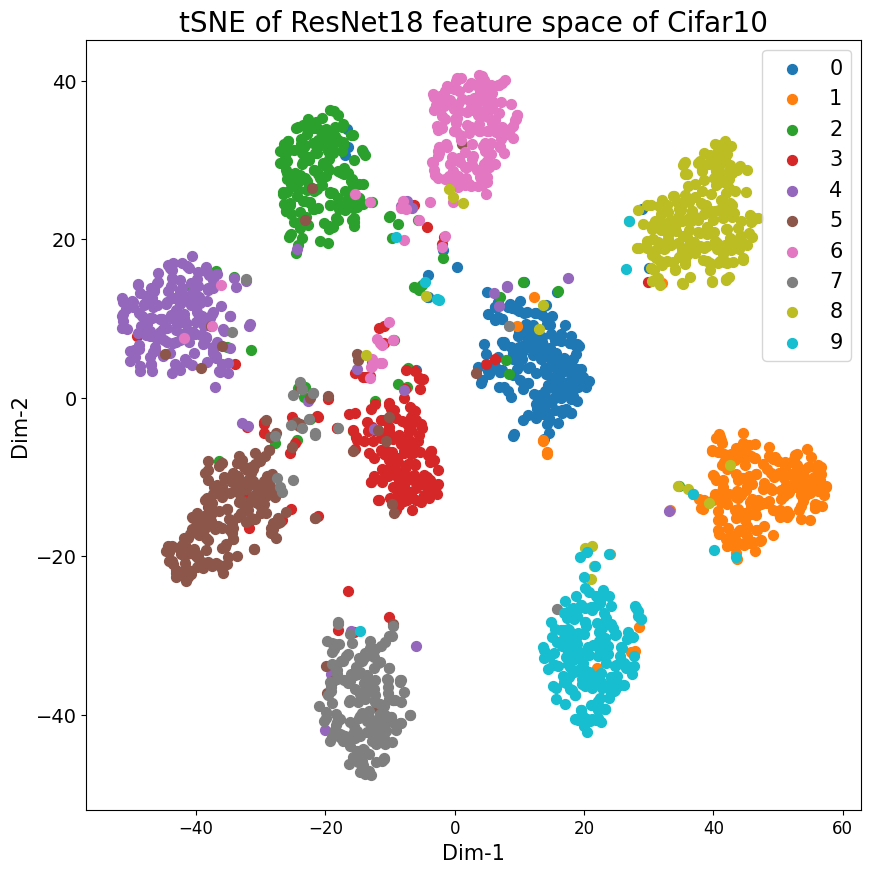

In [28]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Dim-1', fontsize=15)
plt.ylabel('Dim-2', fontsize=15)
plt.title("tSNE of ResNet18 feature space of Cifar10", fontsize=20)
classes = np.arange(10)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for cls, color in zip(classes, colors):
    indicesToKeep = (m_targets == cls).nonzero(as_tuple=True)[0]
    plt.scatter(tsne_data[indicesToKeep, 0], tsne_data[indicesToKeep, 1], c=color, s=50)

plt.legend(classes, prop={'size': 15})

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [29]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [31]:
from skimage.color import rgb2gray

class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
      self.rgbdata = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)


    def __len__(self):
        return len(self.rgbdata)

    def __getitem__(self, index):
      rgbimg = self.rgbdata[index][0]
      rgbimg_ = torch.permute(rgbimg, (1, 2, 0)) # change order of shape
      grayimg = rgb2gray(rgbimg_)

      grayimg = torch.from_numpy(grayimg).reshape((1, rgbimg.shape[1], rgbimg.shape[2]))

      return grayimg, rgbimg


## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [32]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [33]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20)),
])

In [34]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

In [35]:
trainset, valset = train_test_split(initial_trainset, test_size=0.2, random_state=42)

In [36]:
trainset[0][1].shape

torch.Size([3, 32, 32])

In [37]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

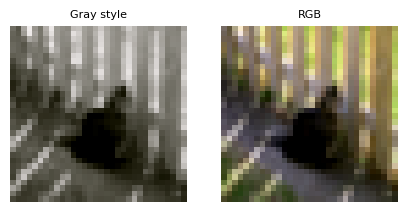

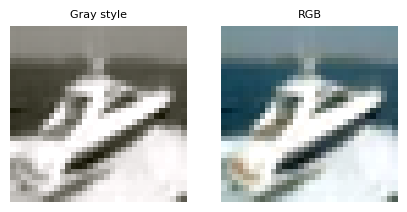

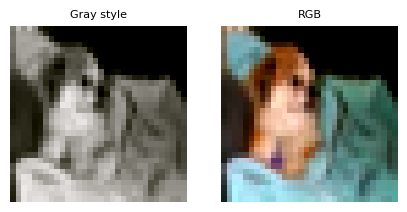

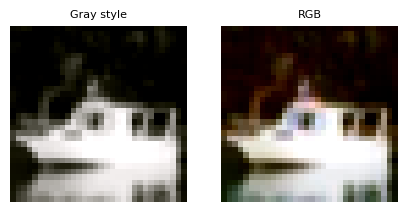

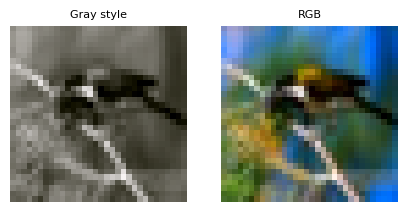

In [38]:
# TODO
num = 5

for i in range(num):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (5, 5))

    index = np.random.randint(0, len(trainset))
    ax1.imshow(np.transpose(norminv(trainset[index][0]), (1, 2, 0)), cmap='gray')
    ax1.set_title("Gray style", fontsize = 8)
    ax1.axis('off')

    ax2.imshow(np.transpose(norminv(trainset[index][1]), (1, 2, 0)))
    ax2.set_title("RGB", fontsize = 8)
    ax2.axis('off')

    plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [ ]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)

        return x

class colorizationNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(colorizationNet, self).__init__()
        self.dwn_conv1 = ConvBlock(in_channels, 64)
        self.dwn_conv2 = ConvBlock(64, 128)
        self.dwn_conv3 = ConvBlock(128, 256)
        self.dwn_conv4 = ConvBlock(256, 512)
        self.dwn_conv5 = ConvBlock(512, 1024)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(1024)

        self.trans_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.trans_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.trans_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.trans_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.up_conv1 = ConvBlock(1024, 512)
        self.up_conv2 = ConvBlock(512, 256)
        self.up_conv3 = ConvBlock(256, 128)
        self.up_conv4 = ConvBlock(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.dwn_conv1(x)
        x2 = self.max_pool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.max_pool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.max_pool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.max_pool(x7)
        x9 = self.dwn_conv5(x8)

        x = self.bn(x9)

        x = self.trans_conv1(x)
        x = torch.cat([x7, x], 1)
        x = self.up_conv1(x)

        x = self.trans_conv2(x)
        x = torch.cat([x5, x], 1)
        x = self.up_conv2(x)

        x = self.trans_conv3(x)
        x = torch.cat([x3, x], 1)
        x = self.up_conv3(x)

        x = self.trans_conv4(x)
        x = torch.cat([x1, x], 1)
        x = self.up_conv4(x)

        x = self.out(x)

        return x


## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [40]:
net = colorizationNet(1,3)
net.to(device)

colorizationNet(
  (dwn_conv1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (dwn_conv2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (dwn_conv3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (dwn_conv4): ConvBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (dwn_conv5): ConvBlock(
    (conv1): Conv2d(512, 1024, kern

In [41]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [42]:
import tqdm
from time import time

In [43]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss = running_loss / len(dataloader)
    return loss

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()

    loss = running_loss / len(dataloader)
    return loss

In [44]:
model_path = data_path + 'colorizerUNet.pt'

epochs = 20

best_valid_loss = float('inf')

loss_hist = {}
loss_hist['train'], loss_hist['valid'] = [], []
for e in range(epochs):
    train_loss = train_epoch(net, criterion, optimizer, trainloader)
    valid_loss = eval_epoch(net, criterion, valloader, test_mode=False)

    # Save checkpoint
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), model_path)

    loss_hist['train'].append(train_loss)
    loss_hist['valid'].append(valid_loss)

    print(f'Epoch [{e+1}/{epochs}] - '
            f'Train Loss: {train_loss:.4f} - '
            f'Valid Loss: {valid_loss:.4f}')

Epoch [1/20] - Train Loss: 0.3893 - Valid Loss: 0.2698
Epoch [2/20] - Train Loss: 0.2528 - Valid Loss: 0.2464
Epoch [3/20] - Train Loss: 0.2379 - Valid Loss: 0.2338
Epoch [4/20] - Train Loss: 0.2312 - Valid Loss: 0.2312
Epoch [5/20] - Train Loss: 0.2275 - Valid Loss: 0.2283
Epoch [6/20] - Train Loss: 0.2250 - Valid Loss: 0.2239
Epoch [7/20] - Train Loss: 0.2228 - Valid Loss: 0.2225
Epoch [8/20] - Train Loss: 0.2208 - Valid Loss: 0.2215
Epoch [9/20] - Train Loss: 0.2186 - Valid Loss: 0.2244
Epoch [10/20] - Train Loss: 0.2164 - Valid Loss: 0.2214
Epoch [11/20] - Train Loss: 0.2136 - Valid Loss: 0.2226
Epoch [12/20] - Train Loss: 0.2102 - Valid Loss: 0.2204
Epoch [13/20] - Train Loss: 0.2058 - Valid Loss: 0.2211
Epoch [14/20] - Train Loss: 0.2006 - Valid Loss: 0.2231
Epoch [15/20] - Train Loss: 0.1959 - Valid Loss: 0.2248
Epoch [16/20] - Train Loss: 0.1896 - Valid Loss: 0.2256
Epoch [17/20] - Train Loss: 0.1834 - Valid Loss: 0.2270
Epoch [18/20] - Train Loss: 0.1780 - Valid Loss: 0.2266
E

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

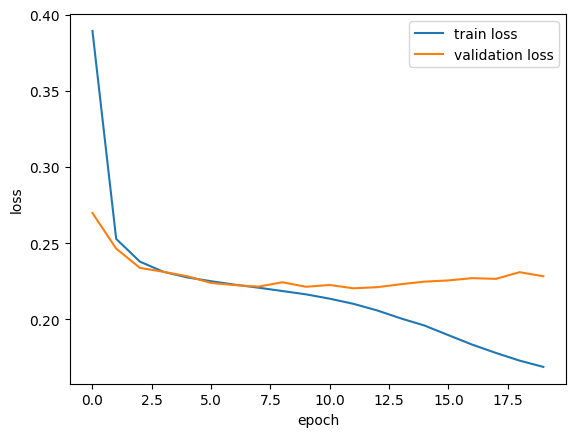

In [45]:
# TODO

def plot(history, metric='loss'):
  epochs = np.arange(len(history['train']))
  plt.plot(epochs, history['train'], label='train ' + metric)
  plt.plot(epochs, history['valid'], label='validation ' + metric)
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend()
  plt.show()

plot(loss_hist, 'loss')

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [47]:
net = colorizationNet(1,3)
net.to(device)

model_path = data_path + 'colorizerUNet.pt'
net.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [48]:
testset = BlackAndWhiteCIFAR10(root='./data', train=False,
                                download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [49]:
# TODO
test_loss = eval_epoch(net, criterion, testloader, test_mode=True)
test_loss

0.21989425111420546

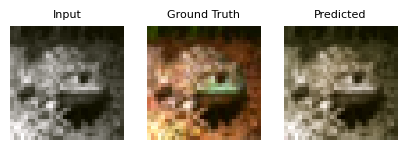

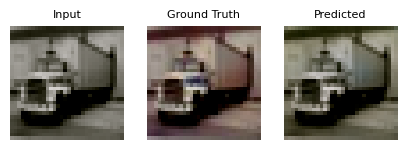

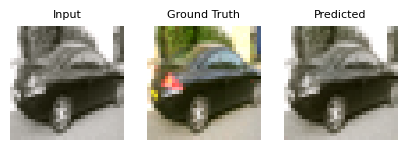

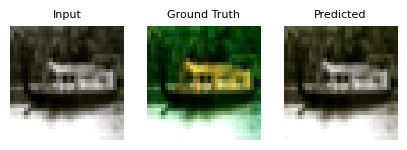

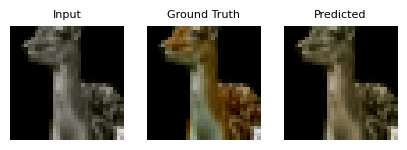

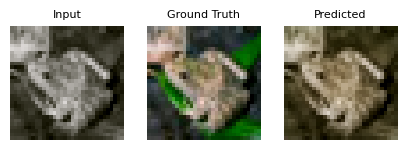

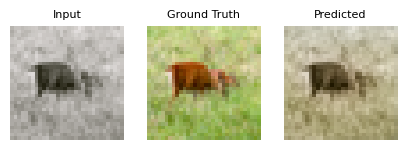

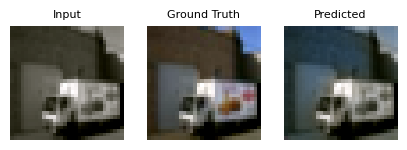

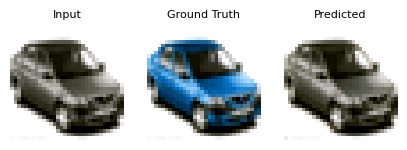

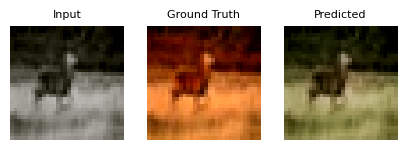

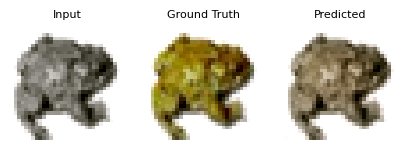

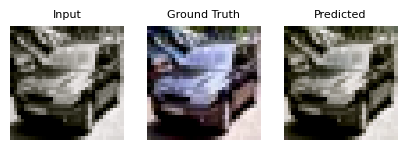

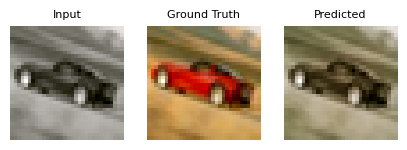

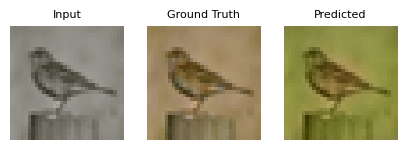

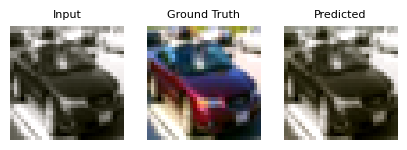

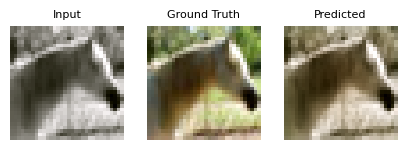

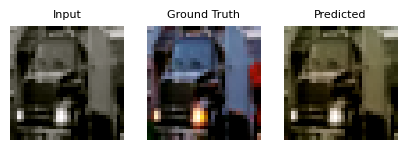

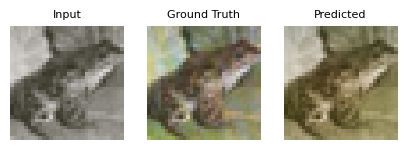

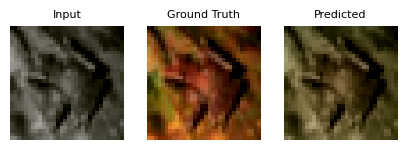

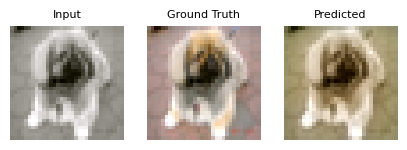

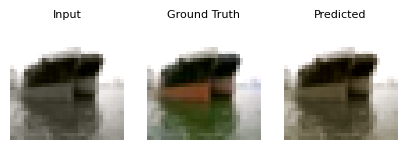

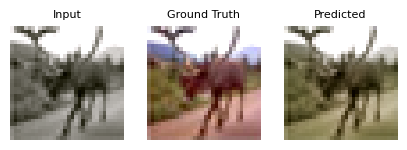

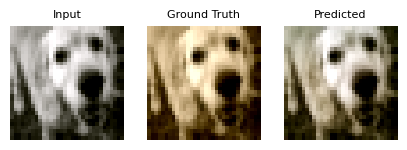

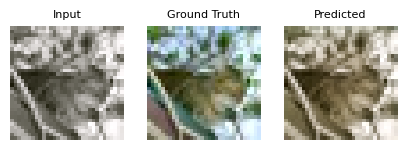

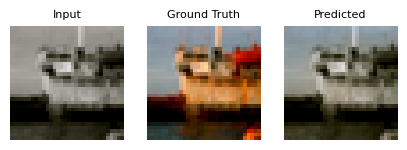

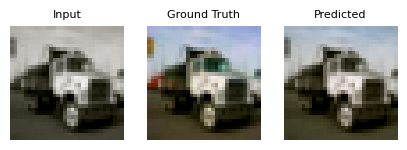

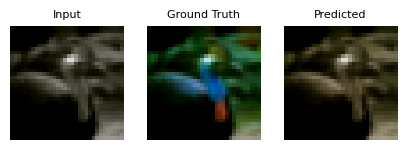

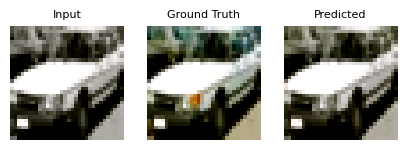

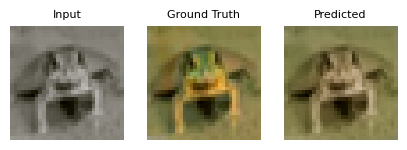

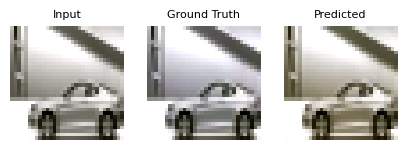

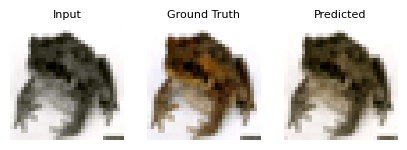

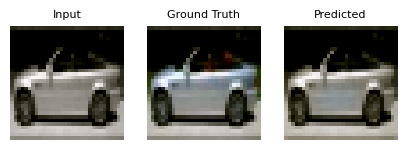

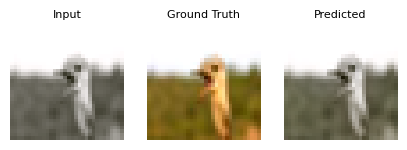

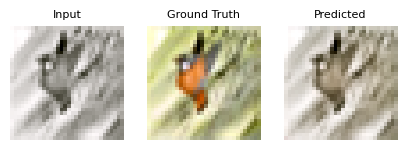

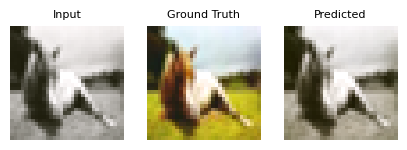

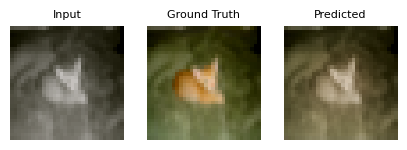

In [50]:
num = 36

for i in range(num):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (5, 5))

    index = np.random.randint(0, len(testset))
    ax1.imshow(np.transpose(norminv(testset[index][0]), (1, 2, 0)), cmap='gray')
    ax1.set_title("Input", fontsize = 8)
    ax1.axis('off')

    ax2.imshow(np.transpose(norminv(testset[index][1]), (1, 2, 0)))
    ax2.set_title("Ground Truth", fontsize = 8)
    ax2.axis('off')

    predicted = net(torch.unsqueeze(testset[index][0], 0).to(device))[0].cpu().detach()
    ax3.imshow(np.transpose(norminv(predicted), (1, 2, 0)))
    ax3.set_title("Predicted", fontsize = 8)
    ax3.axis('off')

    plt.show()